In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import sys
import pickle

In [ ]:
movies = pd.read_csv('/home/movielens/movies.csv')
tags = pd.read_csv('/home/movielens/tags.csv')
ratings = pd.read_csv('/home/movielens/ratings.csv')

In [ ]:
len(movies.movieId.unique())

27278

In [ ]:
len(ratings.movieId.unique())

17082

### Filtering 

In [ ]:
ratings_f = ratings.groupby('userId').filter(lambda x: len(x) >= 55)

In [ ]:
len(ratings_f.movieId.unique())/len(movies.movieId.unique()) * 100

62.36527604663098

In [ ]:
#limit ratings to user ratings that have rated more that 55 movies -- 
#Otherwise it becomes impossible to pivot the rating dataframe later for collaborative filtering.

ratings_f = ratings.groupby('userId').filter(lambda x: len(x) >= 55)

# list the movie titles that survive the filtering
movie_list_rating = ratings_f.movieId.unique().tolist()

In [ ]:
len(ratings_f.movieId.unique())/len(movies.movieId.unique()) * 100

62.36527604663098

In [ ]:
len(ratings_f.userId.unique())/len(ratings.userId.unique()) * 100

58.26926867731126

In [ ]:
movies = movies[movies.movieId.isin(movie_list_rating)]

In [ ]:
movies.head(5)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
Mapping_file = dict(zip(movies.title.tolist(), movies.movieId.tolist()))

In [ ]:
tags.drop(['timestamp'],1, inplace=True)
ratings_f.drop(['timestamp'],1, inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


### Creating Metadata

In [ ]:
merged = pd.merge(movies, tags, on='movieId', how='left')

In [ ]:
merged.head(5)

,movieId,title,genres,userId,tag
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1644.0,Watched
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1741.0,computer animation
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1741.0,Disney animated feature
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1741.0,Pixar animation
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1741.0,TÃ©a Leoni does not star in this movie


In [ ]:
merged.fillna("", inplace=True)
merged = pd.DataFrame(merged.groupby('movieId')['tag'].apply(
                                          lambda x: "%s" % ' '.join(x)))
metadata = pd.merge(movies, merged, on='movieId', how='left')
metadata  ['metadata'] = metadata[['tag', 'genres']].apply(
                                          lambda x: ' '.join(x), axis = 1)
metadata [['movieId','title','metadata']].head(3)

,movieId,title,metadata
0,1,Toy Story (1995),Watched computer animation Disney animated fea...
1,2,Jumanji (1995),time travel adapted from:book board game child...
2,3,Grumpier Old Men (1995),old people that is actually funny sequel fever...


### Creating the Content filter - Latent matrix 1

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(metadata['metadata'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), index=metadata.index.tolist())
print(tfidf_df.shape)

(17012, 22162)


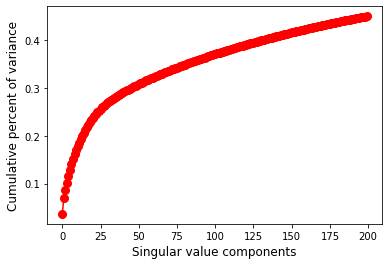

In [ ]:
# Truncate with SVD
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=200)
latent_matrix = svd.fit_transform(tfidf_df)
# plot var expalined to see what latent dimensions to use
explained = svd.explained_variance_ratio_.cumsum()
plt.plot(explained, '.-', ms = 16, color='red')
plt.xlabel('Singular value components', fontsize= 12)
plt.ylabel('Cumulative percent of variance', fontsize=12)        
plt.show()

In [ ]:
n = 200 
latent_matrix_1_df = pd.DataFrame(latent_matrix[:,0:n], index=metadata.title.tolist())

In [ ]:
latent_matrix.shape

(17012, 200)

### Creating a Latent matrix 2

### creating a pivot on ratings data

In [ ]:
ratings1 = pd.merge(movies[['movieId']], ratings_f, on="movieId", how="right")
ratings_pivot = ratings1.pivot(index = 'movieId', columns ='userId', values = 'rating').fillna(0)

In [ ]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=200)
latent_2 = svd.fit_transform(ratings_pivot)
latent_2_df = pd.DataFrame(latent_2,index=metadata.title.tolist())

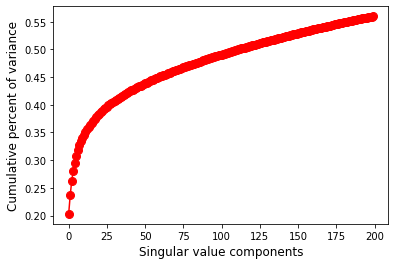

In [ ]:
explained = svd.explained_variance_ratio_.cumsum()
plt.plot(explained, '.-', ms = 16, color='red')
plt.xlabel('Singular value components', fontsize= 12)
plt.ylabel('Cumulative percent of variance', fontsize=12)        
plt.show()

### Hybrid model


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
a_1 = np.array(latent_matrix_1_df.loc['Strada, La (1954)']).reshape(1, -1)
a_2 = np.array(latent_2_df.loc['Strada, La (1954)']).reshape(1, -1)

score_1 = cosine_similarity(latent_matrix_1_df, a_1).reshape(-1)
score_2 = cosine_similarity(latent_2_df, a_2).reshape(-1)

hybrid = ((score_1 + score_2)/2.0)

dictDf = {'content': score_1 , 'collaborative': score_2, 'hybrid': hybrid} 
similar = pd.DataFrame(dictDf, index = latent_matrix_1_df.index )

similar.sort_values('content', ascending=False, inplace=True)

similar[1:].head(11)

,content,collaborative,hybrid
Burnt by the Sun (Utomlyonnye solntsem) (1994),0.789384,0.311801,0.550592
Babette's Feast (Babettes gæstebud) (1987),0.731166,0.595888,0.663527
Purple Noon (Plein soleil) (1960),0.703968,0.411720,0.557844
Mon Oncle (My Uncle) (1958),0.678138,0.793130,0.735634
Sundays and Cybele (Les dimanches de Ville d'Avray) (1962),0.663594,0.442606,0.553100
To Begin Again (a.k.a. Starting Over) (Volver a Empezar) (1982),0.631382,0.262327,0.446855
"Nights of Cabiria (Notti di Cabiria, Le) (1957)",0.628465,0.740375,0.684420
Kolya (Kolja) (1996),0.622818,0.325614,0.474216
Moscow Does Not Believe in Tears (Moskva slezam ne verit) (1979),0.621781,0.587965,0.604873
Journey of Hope (Reise der Hoffnung) (1990),0.615030,0.387955,0.501493
